In [1]:
import numpy as np
import pandas as pd
import os
import random
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt

In [3]:
img_files = os.listdir('/Users/yao/Desktop/detection/training_set/')         # 改
img_files = list(filter(lambda x: x != 'training_set', img_files))
def train_path(p): return f"/Users/yao/Desktop/detection/training_set/{p}"
img_files = list(map(train_path, img_files))

print("total training images", len(img_files))
print("First item", img_files[0])

total training images 5616
First item /Users/yao/Desktop/detection/training_set/@anyuser_1495977824922275840_tweetcapture.png


In [4]:
random.shuffle(img_files)

train = img_files[:4493]  # 改
test = img_files[4493:]

print("train size", len(train))
print("test size", len(test))


train size 4493
test size 1123


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [65]:
class tweetdataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'anyuser' in path else 1
        return (image, label)

In [54]:
# from torch.utils.data import Dataset
# class custom_subset(Dataset):
#     r"""
#     Subset of a dataset at specified indices.

#     Arguments:
#         dataset (Dataset): The whole Dataset
#         indices (sequence): Indices in the whole set selected for subset
#         labels(sequence) : targets as required for the indices. will be the same length as indices
#     """
#     def __init__(self, dataset, indices, labels):
#         self.dataset = torch.utils.data.Subset(dataset, indices)
#         self.targets = labels
#     def __getitem__(self, idx):
#         image = self.dataset[idx][0]
#         target = self.targets[idx]
#         return (image, target)

#     def __len__(self):
#         return len(self.targets)

In [66]:
train_ds = tweetdataset(train, transform)
train_dl = DataLoader(train_ds, batch_size=100)
print(len(train_ds), len(train_dl))


4493 45


In [8]:
test_ds = tweetdataset(test, transform)
test_dl = DataLoader(test_ds, batch_size=100)
print(len(test_ds), len(test_dl))

1123 12


In [9]:
class tweetscreenshot(nn.Module):

    def __init__(self):
        super().__init__()

        # onvolutional layers (3,16,32)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)

        # conected layers
        self.fc1 = nn.Linear(in_features= 64 * 6 * 6, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=2)


    def forward(self, X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)

        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return X

In [11]:
model = tweetscreenshot()

losses = []
accuracies = []
epoches = 3
start = time.time()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [12]:
for epoch in range(epoches):

    epoch_loss = 0
    epoch_accuracy = 0

    for X, y in train_dl:
        preds = model(X)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)

    epoch_accuracy = epoch_accuracy/len(train_dl)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dl)
    losses.append(epoch_loss)

    print("\n --- Epoch: {}, train loss: {:.4f}, train acc: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))
    
    with torch.no_grad():

        test_epoch_loss = 0
        test_epoch_accuracy = 0

        for test_X, test_y in test_dl:

            test_preds = model(test_X)
            test_loss = loss_fn(test_preds, test_y)

            test_epoch_loss += test_loss            
            test_accuracy = ((test_preds.argmax(dim=1) == test_y).float().mean())
            test_epoch_accuracy += test_accuracy

        test_epoch_accuracy = test_epoch_accuracy/len(test_dl)
        test_epoch_loss = test_epoch_loss / len(test_dl)

        print("Epoch: {}, test loss: {:.4f}, test acc: {:.4f}, time: {}\n".format(epoch, test_epoch_loss, test_epoch_accuracy, time.time() - start))

...

/Users/yao/miniconda3/lib/python3.8/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


..........................................
 --- Epoch: 0, train loss: 0.2720, train acc: 0.8899, time: 109.63032007217407
Epoch: 0, test loss: 0.1689, test acc: 0.9289, time: 131.93170285224915

.............................................
 --- Epoch: 1, train loss: 0.1160, train acc: 0.9590, time: 229.84175491333008
Epoch: 1, test loss: 0.0589, test acc: 0.9875, time: 251.29328083992004

.............................................
 --- Epoch: 2, train loss: 0.0512, train acc: 0.9846, time: 347.5734179019928
Epoch: 2, test loss: 0.0443, test acc: 0.9880, time: 367.75361490249634



In [13]:
test_files = os.listdir('/Users/yao/Desktop/detection/test_set/')
test_files = list(filter(lambda x: x != 'test_set', test_files))
def test_path(p): return f"/Users/yao/Desktop/detection/test_set/{p}"
test_files = list(map(test_path, test_files))

class Test(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        fileid = path.split('/')[-1].split('.')[0]
        return (image, fileid)

test_ds = Test(test_files, transform)
test_dl = DataLoader(test_ds, batch_size=100)
len(test_ds), len(test_dl)


(1403, 15)

In [14]:
screenshot_probs = []

with torch.no_grad():
    for X, fileid in test_dl:
        preds = model(X)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        screenshot_probs += list(zip(list(fileid), preds_list))



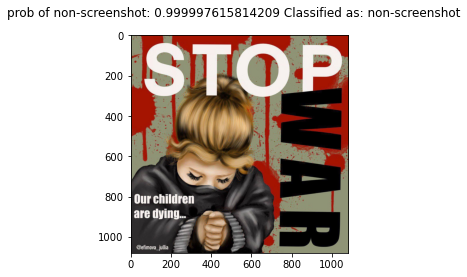

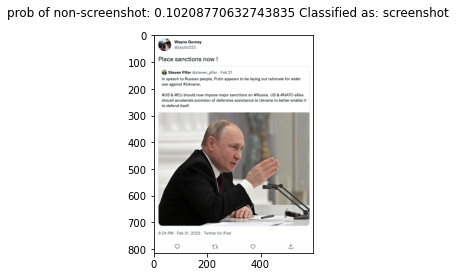

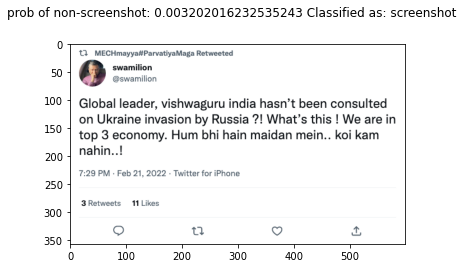

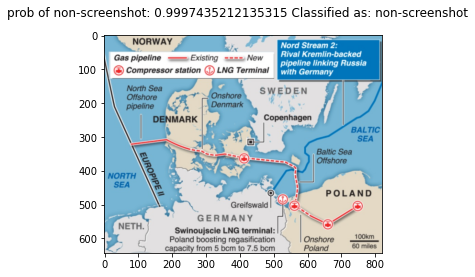

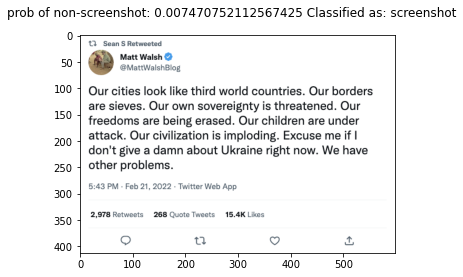

In [15]:
# display some images
for img, probs in zip(test_files[:5], screenshot_probs[:5]):
    pil_im = Image.open(img, 'r')
    label = "non-screenshot" if probs[1] > 0.5 else "screenshot"
    title = "prob of non-screenshot: " + str(probs[1]) + " Classified as: " + label
    plt.figure()
    plt.imshow(pil_im)
    plt.suptitle(title)
    plt.show()

In [ ]:
#target_names = ['Screenshot', 'Non-Screenshot']
#from sklearn.metrics import classification_report
#print(classification_report(test_files, screenshot_probs, target_names=target_names))

In [36]:
@torch.no_grad()
def get_all_prediction(model, loader):
    preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        batch_predictions = model(images)
        preds = torch.cat((preds, batch_predictions), dim = 0)
    return preds



In [87]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [38]:
#print(model.metrics_names)

In [39]:
#loss, accuracy = model.evaluate(train_ds, train_ds[y], verbose=1)
#loss_v, accuracy_v = model.evaluate(test_ds[X], test_ds[y], verbose=1)
#print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
#print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

In [77]:
train_preds = get_all_prediction(model, train_dl)
type(train_preds)

torch.Tensor

In [78]:
print(train_preds.argmax(dim=1))

tensor([1, 0, 0,  ..., 0, 0, 0])


/Users/yao/miniconda3/lib/python3.8/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Confusion matrix, without normalization
[[2214   38]
 [   6 2235]]
AxesSubplot(0.140394,0.329546;0.667685x0.577398)


<Figure size 3600x3600 with 0 Axes>

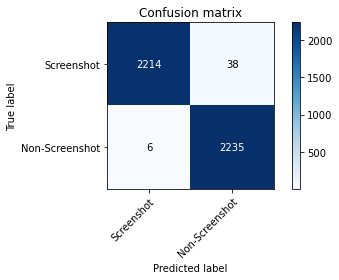

Accuracy: 0.9902069886490096
F1: 0.9902066626455707


In [89]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

np.set_printoptions(precision=2)

train_preds = get_all_prediction(model, train_dl)
label_dict = {
 'Screenshot', 'Non-Screenshot'
}

train_label=[]
for i in range(0,len(train_ds)):
    train_label.append(train_ds.__getitem__(i)[1])
train_label= torch.FloatTensor(train_label)


# Plot non-normalized confusion matrix


plt.figure(figsize=(50,50))
a=plot_confusion_matrix(train_label, train_preds.argmax(dim=1), classes=label_dict,
                      title='Confusion matrix')
print(a)
plt.show()

print('Accuracy:', accuracy_score(train_label, train_preds.argmax(dim=1)))
print('F1:', f1_score(train_label, train_preds.argmax(dim=1), average='weighted'))

In [96]:
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
print('Recall:', recall_score(train_label, train_preds.argmax(dim=1)))
print('Roc-Auc:', roc_auc_score(train_label, train_preds.argmax(dim=1)))

Recall: 0.9973226238286479
Roc-Auc: 0.990224366976491


In [84]:
train_label=[]
for i in range(0,len(train_ds)):
    train_label.append(train_ds.__getitem__(i)[1])
train_label= torch.FloatTensor(train_label)
train_label

tensor([1., 0., 1.,  ..., 0., 0., 0.])

In [92]:
test_preds = get_all_prediction(model, test_dl)
test_preds

tensor([[-8.6201,  4.3285],
        [ 0.2301, -1.9442],
        [ 1.7718, -3.9690],
        ...,
        [-6.2001,  3.1355],
        [ 0.8823, -2.8901],
        [ 1.7174, -4.0194]])